In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, make_scorer, brier_score_loss
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from joblib import dump, load
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
plt.style.use('dark_background')
# monkey patch for bayesseachcv (https://github.com/scikit-optimize/scikit-optimize/issues/902)
from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray
from skopt import BayesSearchCV
from skopt.space import Real, Integer

Random state

In [2]:
seed = 42

Setup metrics (see: http://business-analytic.co.uk/blog/evaluating-expected-goals-models/)

In [3]:
# define Mcfadden's pseduo r-squared
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [4]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

Setup folder for storing models

Load the data

In [5]:
df = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout'], axis=1, inplace=True)
X = df.drop('goal', axis=1)
y = df.goal

Split into train, calibration and test datasets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.65, random_state=seed, stratify=y)
X_calibration, X_test, y_calibration, y_test = train_test_split(X_test, y_test,
                                                                train_size=0.7, random_state=seed, stratify=y_test)

In [7]:
print('Shots test', len(y_train), ';Goals %: ', round(y_train.mean()*100, 1))
print('Shots calibration', len(y_calibration), ';Goals %: ', round(y_calibration.mean()*100, 1))
print('Shots test', len(y_test), ';Goals %: ', round(y_test.mean()*100, 1))

Shots test 41857 ;Goals %:  10.6
Shots calibration 15777 ;Goals %:  10.6
Shots test 6762 ;Goals %:  10.6


# Logistic regression

Subset dataset for logistic regression

In [8]:
# drop colum
logistic_drop_cols = ['x', 'y',  # logistic regression does not deal well with dependent features
                      # The model will use the distance/ angle features capture these location features instead
                      # lots of missings for the below features as they come from StatsBomb data only.
                      # It's not fair to impute these as they are not missing at random
                      # while logistic regression does not allow missings so I removed them
                      'pass_end_y', 'pass_end_x',  # <- note these were in Wyscout, but often were just the shot location
                      'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal',
                      'under_pressure', 'area_shot', 'area_goal', 'n_angle']
X_train_logistic = X_train.drop(logistic_drop_cols, axis=1).copy()
X_test_logistic = X_test.drop(logistic_drop_cols, axis=1).copy()
X_calibration_logistic = X_calibration.drop(logistic_drop_cols, axis=1).copy()

Split dataset for logistic regession into passes / other assists

In [9]:
def split(X, y):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    y_pass = y[mask]
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    y_other = y[~mask]
    return X_pass, y_pass, X_other, y_other

In [10]:
X_train_pass, y_train_pass, X_train_other, y_train_other = split(X_train_logistic, y_train)
X_calibration_pass, y_calibration_pass, X_calibration_other, y_calibration_other = split(X_calibration_logistic, y_calibration)
X_test_pass, y_test_pass, X_test_other, y_test_other = split(X_test_logistic, y_test)

Pipeline for cleaning pass assists

In [11]:
cols = ['shot_type_name', 'body_part_name', 'pass_technique_name', 'pass_height_name']
cats = [['open_play', 'free_kick', 'corner', 'throw_in'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging'],
        ['Ground/ Low Pass', 'High Pass']]
pass_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_pass = Pipeline([('one_hot', pass_one_hot),
                      ('impute', SimpleImputer()),
                      ('scale', StandardScaler()),
                      ('lr', LogisticRegression(random_state=seed))])

Column names of transformed pass data

In [12]:
original_cols_remain = [col for col in X_train_pass.columns if col not in cols]
new_cols_pass = [item for sublist in cats for i, item in enumerate(sublist) if (i>0)]
new_cols_pass.extend(original_cols_remain)

In [13]:
print(new_cols_pass)

['free_kick', 'corner', 'throw_in', 'Left Foot', 'Other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging', 'High Pass', 'counter_attack', 'fast_break', 'strong_foot', 'pass_switch', 'pass_cross', 'pass_cut_back', 'visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle', 'log_distance_to_goal']


Pipeline for cleaning other assists

In [14]:
cols = ['shot_type_name', 'body_part_name', 'assist_type']
cats = [['open_play', 'free_kick', 'corner', 'throw_in', 'direct_set_piece'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['recovery', 'clearance', 'direct', 'rebound']]
other_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_other = Pipeline([('one_hot', other_one_hot),
                       ('impute', SimpleImputer()),
                       ('scale', StandardScaler()),
                       ('lr', LogisticRegression(random_state=seed))])

Column names of transformed passes

In [15]:
original_cols_remain = [col for col in X_train_other.columns if col not in cols]
new_cols_other = [item for sublist in cats for i, item in enumerate(sublist) if (i>0)]
new_cols_other.extend(original_cols_remain)

In [16]:
print(new_cols_other)

['free_kick', 'corner', 'throw_in', 'direct_set_piece', 'Left Foot', 'Other', 'clearance', 'direct', 'rebound', 'counter_attack', 'fast_break', 'strong_foot', 'visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle', 'log_distance_to_goal']


Search parameters for gridsearchcv

In [17]:
param_grid = {'lr__C': np.logspace(-3, 0.1, 100)}

Fit the inner grid search for shots assisted by passes

In [18]:
clf_pass = GridSearchCV(estimator=pipe_pass, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_pass.fit(X_train_pass, y_train_pass)
print('C:', clf_pass.best_estimator_.named_steps.lr.C)

C: 0.03953390342037077


Fit the inner grid search for shots assisted other than passes

In [19]:
clf_other = GridSearchCV(estimator=pipe_other, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_other.fit(X_train_other, y_train_other)
print('C:', clf_other.best_estimator_.named_steps.lr.C)

C: 0.09391333704859804


Outer loops for unbiased estimates of the model accuracy

In [20]:
nested_score_pass = cross_validate(clf_pass, X=X_train_pass, y=y_train_pass, scoring=scoring, n_jobs=-1)
print('ROC AUC for shots assisted by passes:', nested_score_pass['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared shots assisted by passes:", nested_score_pass['test_mcfaddens_r2'].mean())

ROC AUC for shots assisted by passes: 0.7786189955979456
McFadden's Pseudo R-squared shots assisted by passes: 0.15597580105735084


In [21]:
nested_score_other = cross_validate(clf_other, X=X_train_other, y=y_train_other, scoring=scoring, n_jobs=-1)
print('ROC AUC for other model:', nested_score_other['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared for other model:", nested_score_other['test_mcfaddens_r2'].mean())

ROC AUC for other model: 0.798461930405478
McFadden's Pseudo R-squared for other model: 0.1852039525842921


# LightGBM model

Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.

In [22]:
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one', 'shot_open_goal', 'under_pressure']:
        df[col] = df[col].astype(np.float32)
    # drop some distance/ angle columns
    drop_cols = ['visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle', 'log_distance_to_goal']
    df.drop(drop_cols, axis=1, inplace=True)
    return df
    
X_train = clean_lightgbm(X_train)
X_test = clean_lightgbm(X_test)
X_calibration = clean_lightgbm(X_calibration)

Hierarchical clustering

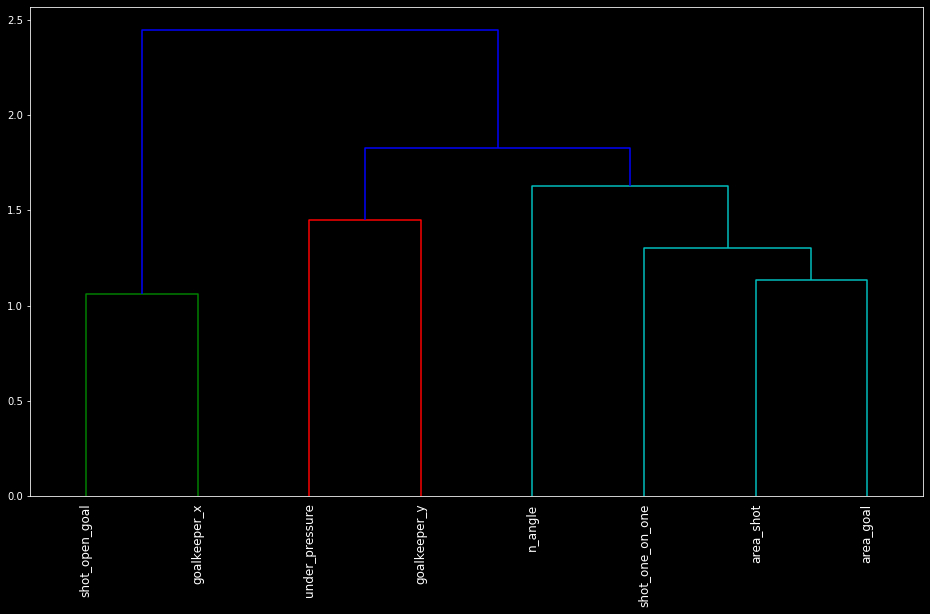

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
corr = spearmanr(X_train.dropna(how='any', axis=1)).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=X_train.columns, ax=ax, leaf_rotation=90)

Fit the nested 5-fold cross validation using Bayesian optimisation.

In [24]:
lgbm = LGBMClassifier(random_state=42)
lgbm_param_grid = {'min_child_samples': Integer(0, 200),
                   'num_leaves': Integer(2, 500),
                   'reg_lambda': Real(0, 1),
                   'reg_alpha': Real(0, 1),
                   'max_depth': Integer(0, 500)}
# Nested resampling using skopt. see: https://github.com/scikit-optimize/scikit-optimize/issues/725
searchcv = BayesSearchCV(estimator=lgbm,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
searchcv.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
              search_spaces={'max_depth': Integer(low=0, high=500, prior='uniform', transform='identity'),
                             'min_child_samples': Integer(low=0, high=200, prior='uniform', transform='identity'),
                             'num_leaves': Integer(low=2, high=500, prior='uniform', transform='identity'),
                             'reg_alpha': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'reg_lambda': Real(low=0, high=1, prior='uniform', transform='identity')})

Permutation importance

In [25]:
perm_result = permutation_importance(searchcv.best_estimator_, X_train, y_train, n_repeats=10, random_state=seed)
df_perm_importance = pd.DataFrame({'Feature':X_train.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)
features_to_drop = df_perm_importance[df_perm_importance.importance < 0.0001].Feature.unique()

In [26]:
df_perm_importance

,Feature,importance,std_dev
0,x,1.669494e-02,0.000400
1,y,1.122154e-02,0.000382
2,goalkeeper_x,1.739255e-03,0.000240
3,body_part_name,1.478845e-03,0.000262
4,shot_type_name,1.206489e-03,0.000268
5,n_angle,1.132427e-03,0.000323
6,pass_technique_name,6.402752e-04,0.000119
7,shot_open_goal,6.044389e-04,0.000087
8,pass_end_y,5.088755e-04,0.000130
9,area_goal,3.679193e-04,0.000080


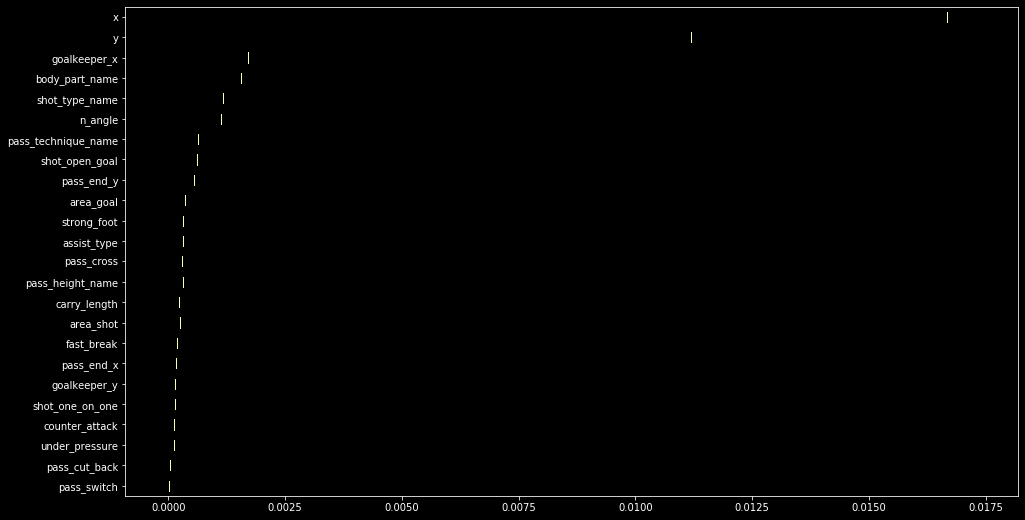

In [27]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])

Drop features that aren't important

In [28]:
print('Dropped features', features_to_drop)
X_train.drop(features_to_drop, axis=1, inplace=True)
X_calibration.drop(features_to_drop, axis=1, inplace=True)
X_test.drop(features_to_drop, axis=1, inplace=True)

Dropped features ['pass_cut_back' 'pass_switch']


Inner loop cross-validation - now features are removed

In [29]:
searchcv.fit(X_train, y_train)

C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\opt

BayesSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
              search_spaces={'max_depth': Integer(low=0, high=500, prior='uniform', transform='identity'),
                             'min_child_samples': Integer(low=0, high=200, prior='uniform', transform='identity'),
                             'num_leaves': Integer(low=2, high=500, prior='uniform', transform='identity'),
                             'reg_alpha': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'reg_lambda': Real(low=0, high=1, prior='uniform', transform='identity')})

Outer loop for unbiased estimates

In [30]:
nested_score_lgbm = cross_validate(searchcv, X=X_train, y=y_train, scoring=scoring, n_jobs=1)
print('ROC AUC (LGBM):', nested_score_lgbm['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared (LGBM):", nested_score_lgbm['test_mcfaddens_r2'].mean())

C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\AndrewRowlinson\Anaconda3\envs\expected-goals\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


ROC AUC (LGBM): 0.7866387442039467
McFadden's Pseudo R-squared (LGBM): 0.16825108243822356


# Calibrate lgbm model

Make predictions on calibration data

In [31]:
# predictions
y_pred_lr_pass = clf_pass.predict_proba(X_calibration_pass)[:, 1]
y_pred_lr_other = clf_other.predict_proba(X_calibration_other)[:, 1]
y_pred_lgbm = searchcv.predict_proba(X_calibration)[:, 1]
# concatenate logistic regression results
y_pred_lr = np.concatenate([y_pred_lr_pass, y_pred_lr_other])
y_true_calibration = np.concatenate([y_calibration_pass, y_calibration_other])

Plot calibration curve

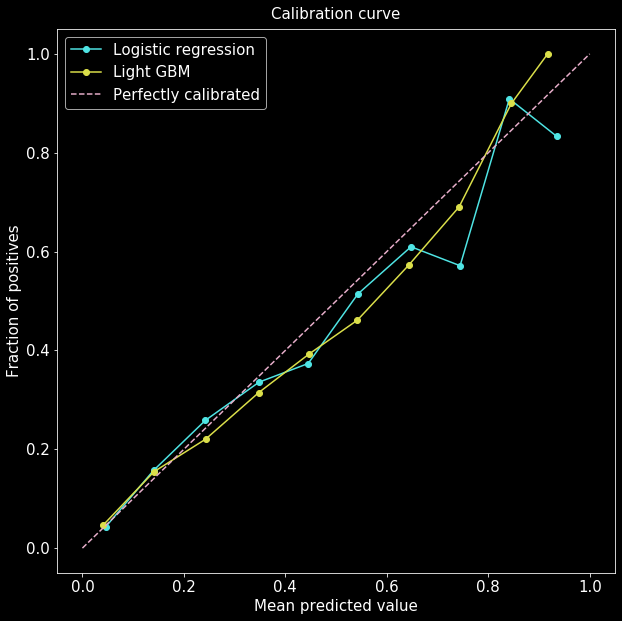

In [32]:
# create curves
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_calibration, y_pred_lr, n_bins=10)
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_calibration, y_pred_lgbm, n_bins=10)
# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#4fe4e4', label='Logistic regression')
ax.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#dbdf4a', label='Light GBM')
ax.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax.set_xlabel('Mean predicted value', fontsize=15)
ax.set_ylabel('Fraction of positives', fontsize=15)
ax.set_title('Calibration curve', fontsize=15, pad=10)
ax.legend(fontsize=15)
ax.tick_params(labelsize=15)

Calibrate Light GBM model

In [33]:
sigmoid_calibration = CalibratedClassifierCV(searchcv.best_estimator_, method='isotonic', cv=3)
sigmoid_calibration.fit(X_calibration, y_calibration)

CalibratedClassifierCV(base_estimator=LGBMClassifier(max_depth=500,
                                                     min_child_samples=0,
                                                     num_leaves=51,
                                                     random_state=42,
                                                     reg_alpha=1.0,
                                                     reg_lambda=1.0),
                       cv=3, method='isotonic')

# Test

Calculate calibration curve on test data

In [34]:
y_pred_lgbm_calibrated = sigmoid_calibration.predict_proba(X_test)[:, 1]
fraction_of_positives_calib, mean_predicted_value_calib = calibration_curve(y_test, y_pred_lgbm_calibrated, n_bins=10)
# logistic regression
y_pred_lr_pass = clf_pass.predict_proba(X_test_pass)[:, 1]
y_pred_lr_other = clf_other.predict_proba(X_test_other)[:, 1]
y_pred_lr = np.concatenate([y_pred_lr_pass, y_pred_lr_other])
y_true_calibration = np.concatenate([y_test_pass, y_test_other])
fraction_of_positives_test, mean_predicted_value_test = calibration_curve(y_true_calibration, y_pred_lr, n_bins=10)

Plot calibration curve on test data

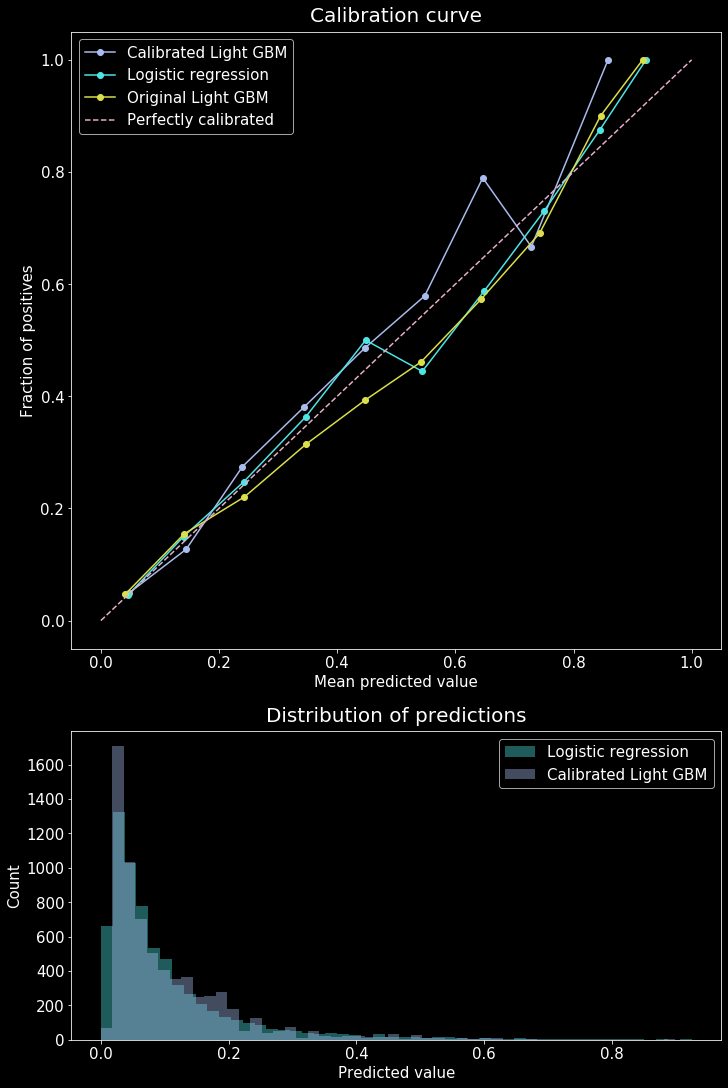

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_calib, fraction_of_positives_calib, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_test, fraction_of_positives_test, "-o", color='#4fe4e4', label='Logistic regression')
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#dbdf4a', label='Original Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lr, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
sns.distplot(y_pred_lgbm_calibrated, color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

From scikit-learn docs: "The smaller the Brier score, the better, hence the naming with “loss”. Across all items in a set N predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome."

In [36]:
print('Brier score, Light GBM:', brier_score_loss(y_test, y_pred_lgbm_calibrated, pos_label=y_test.max()))
print('ROC AUC, Light GBM:', roc_auc_score(y_test, y_pred_lgbm_calibrated))
print('Pseudo R-squared, Light GBM:', mcfadden_r2(y_test, y_pred_lgbm_calibrated))

Brier score, Light GBM: 0.08237224809506785
ROC AUC, Light GBM: 0.7712783662510574
Pseudo R-squared, Light GBM: 0.1517719699091049


In [37]:
print('Brier score, logistic regression:',brier_score_loss(y_true_calibration, y_pred_lr, pos_label=y_true_calibration.max()))
print('ROC AUC, logistic regression:', roc_auc_score(y_true_calibration, y_pred_lr))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_true_calibration, y_pred_lr))

Brier score, logistic regression: 0.08140298323183572
ROC AUC, logistic regression: 0.7812394258707566
Pseudo R-squared, logistic regression: 0.1623070554332301


# Save models

In [38]:
dump(sigmoid_calibration, os.path.join('..', 'models', 'lgbm_model.joblib'))

['..\\models\\lgbm_model.joblib']

In [39]:
dump(clf_pass.best_estimator_, os.path.join('..', 'models', 'lr_pass.joblib'))

['..\\models\\lr_pass.joblib']

In [40]:
dump(clf_other.best_estimator_, os.path.join('..', 'models', 'lr_other.joblib'))

['..\\models\\lr_other.joblib']

# Save data

In [41]:
X_train_other['goal'] = y_train_other
X_train_other['split'] = 'train'
X_calibration_other['goal'] = y_calibration_other
X_calibration_other['split'] = 'calibration'
X_test_other['goal'] = y_test_other
X_test_other['split'] = 'test'
df_other = pd.concat([X_train_other, X_calibration_other, X_test_other])
df_other.reset_index(drop=True, inplace=True)
df_other.to_parquet(os.path.join('..', 'data', 'modelling', 'lr_other.parquet'))

In [42]:
X_train_pass['goal'] = y_train_pass
X_train_pass['split'] = 'train'
X_calibration_pass['goal'] = y_calibration_pass
X_calibration_pass['split'] = 'calibration'
X_test_pass['goal'] = y_test_pass
X_test_pass['split'] = 'test'
df_pass = pd.concat([X_train_pass, X_calibration_pass, X_test_pass])
df_pass.reset_index(drop=True, inplace=True)
df_pass.to_parquet(os.path.join('..', 'data', 'modelling', 'lr_pass.parquet'))

In [43]:
X_train['goal'] = y_train
X_train['split'] = 'train'
X_calibration['goal'] = y_calibration
X_calibration['split'] = 'calibration'
X_test['goal'] = y_test
X_test['split'] = 'test'
df_lgbm = pd.concat([X_train, X_calibration, X_test])
df_lgbm.reset_index(drop=True, inplace=True)
df_lgbm.to_parquet(os.path.join('..', 'data', 'modelling', 'lgbm.parquet'))